In [1]:
import shap
import xgboost as xgb
import pandas as pd
from sklearn.model_selection import train_test_split
from pdpbox import pdp, info_plots
import numpy as np
from scipy.stats import randint, uniform

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    average_precision_score,
)
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt

import sys
import os
import warnings


if not sys.warnoptions:
    warnings.simplefilter("ignore")
    os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
path = "https://raw.githubusercontent.com/nogibjj/IDS705_FinalProject_Lemur_Team/main/01_clean_data/adult_ohe.csv"

adult_ohe = pd.read_csv(path)

X = adult_ohe.drop(columns=["income"])
y = adult_ohe["income"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
param_dist = {
    "n_estimators": list(range(50, 3001, 200)),
    "max_depth": list(range(10, 100, 10)),
    "learning_rate": np.logspace(-4, -1, 20),
    "subsample": np.arange(0.5, 1.0, 0.2).tolist(),
    "colsample_bytree": np.arange(0.5, 1.0, 0.2).tolist(),
    "reg_alpha": [0, 0.001, 0.01, 0.1, 1, 10],
    "reg_lambda": [0, 0.001, 0.01, 0.1, 1, 10],
    "gamma": np.logspace(-4, 0, 5),
    "min_child_weight": [3, 4, 5, 6, 7, 8, 9, 10],
}

xgb_clf = xgb.XGBClassifier(
    objective="binary:logistic", eval_metric="logloss", random_state=42
)

random_search = RandomizedSearchCV(
    xgb_clf,
    param_distributions=param_dist,
    n_iter=100,
    cv=5,
    scoring="accuracy",
    random_state=42,
)

random_search.fit(X_train, y_train)

best_params = random_search.best_params_
best_model = random_search.best_estimator_
best_params

{'subsample': 0.7,
 'reg_lambda': 0.001,
 'reg_alpha': 10,
 'n_estimators': 850,
 'min_child_weight': 3,
 'max_depth': 70,
 'learning_rate': 0.04832930238571752,
 'gamma': 1.0,
 'colsample_bytree': 0.5}

In [4]:
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]
auc_roc = roc_auc_score(y_test, y_pred_proba)
auc_pr = average_precision_score(y_test, y_pred_proba)


print(f"Accuracy: {accuracy:.3f}")
print(f"Precision: {precision:.3f}")
print(f"Recall: {recall:.3f}")
print(f"F1 Score: {f1:.3f}")
print(f"AUC - ROC: {auc_roc:.3f}")
print(f"AUC - PR: {auc_pr:.3f}")

Accuracy: 0.872
Precision: 0.782
Recall: 0.653
F1 Score: 0.712
AUC - ROC: 0.924
AUC - PR: 0.822


In [5]:
def f(x):
    return best_model.predict_proba(x)[:, 1]


med = X_train.median().values.reshape((1, X_train.shape[1]))

explainer = shap.Explainer(f, med)
shap_values = explainer(X_test)

PermutationExplainer explainer: 9770it [01:38, 90.05it/s]                           


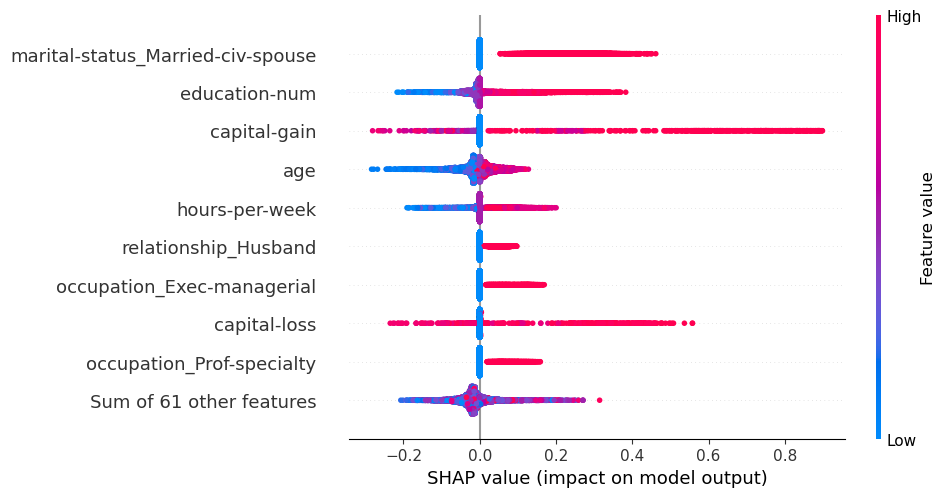

In [6]:
shap.plots.beeswarm(shap_values)

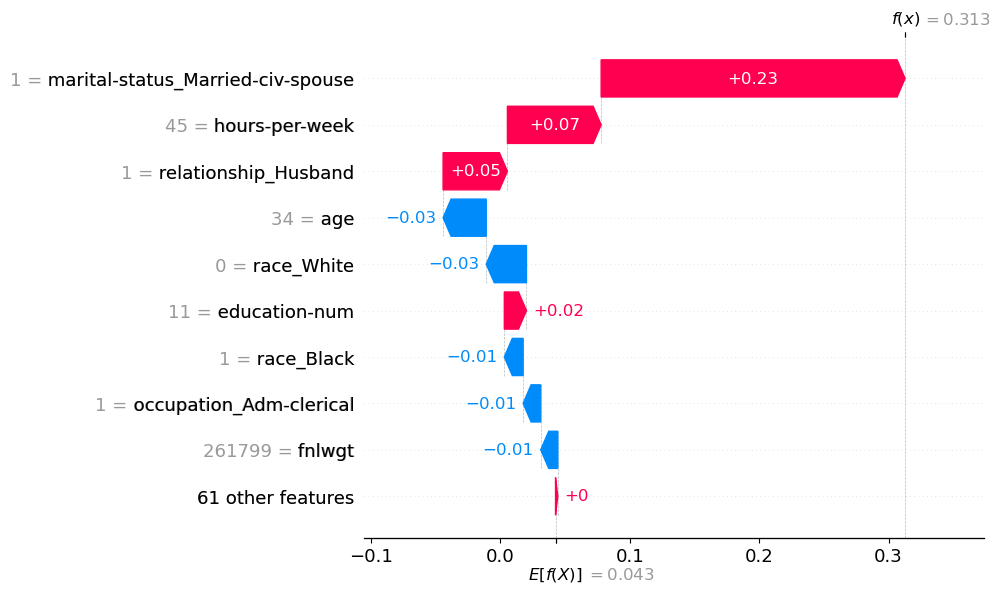

In [7]:
shap.plots.waterfall(shap_values[11])

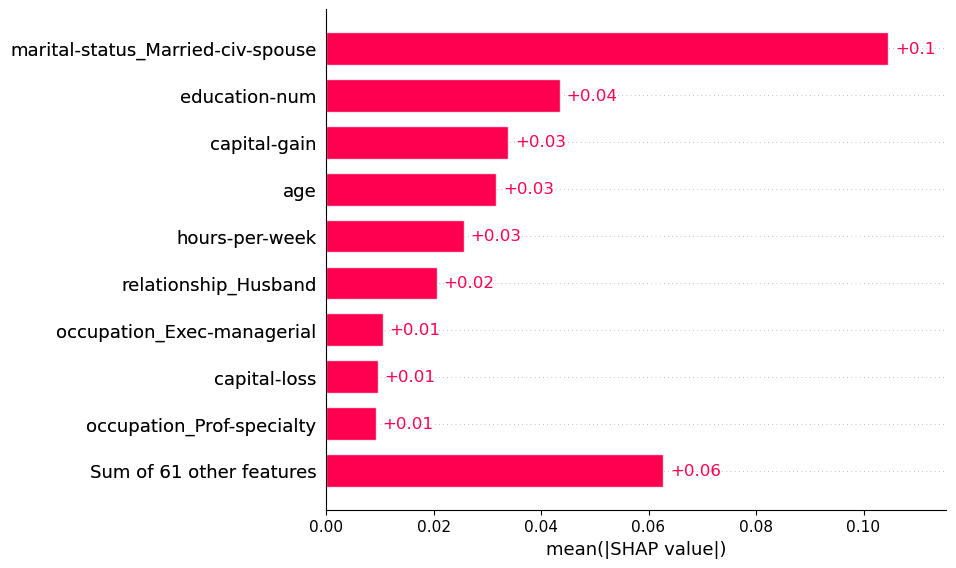

In [8]:
shap.plots.bar(shap_values)

In [9]:
# Result for AUC PR curves
results = pd.DataFrame({"score": y_pred_proba})
results.index.name = "id"
results.to_csv("../40_results/xgboost_prob.csv")